# <b>Custom object detection training demo</b>

The AIServiceVisionClient offers the feature to create and train a custom object detection model by giving a training dataset. The model is then used for inferencing over a sample image for testing the trained model. <br>This notebook aims to provide overall clarity about the feature to the user in terms of requirements, usage and the output of the API.<br>

#### Installing the OCI Vision SDK

In [ ]:
# !pip3 install oci-cli
# !pip3 install oci==2.57.0

#### Installing other dependencies

In [ ]:
# !pip install matplotlib
# !pip install pandas

## Setup dataset in Object Storage

In [ ]:
import oci
config = oci.config.from_file('~/.oci/config')

In [ ]:
# Specify the Namespace and Compartment ID where you want to create a bucket for the dataset
NAMESPACE_NAME = "<NAMESPACE-NAME>"
COMPARTMENT_ID = "<COMPARTMENT-OCID>"

In [ ]:
# Creates bucket "starbucks-dataset"
object_storage_client = oci.object_storage.ObjectStorageClient(config)
create_bucket_response = object_storage_client.create_bucket(
    namespace_name=NAMESPACE_NAME,
    create_bucket_details=oci.object_storage.models.CreateBucketDetails(
        name="starbucks-dataset",
        compartment_id=COMPARTMENT_ID)
)

# Uploads images to the bucket
!oci os object bulk-upload -bn starbucks-dataset --src-dir images --prefix images/

# Uploads the labelling file and the file metadata to the bucket
!oci os object put -ns {NAMESPACE_NAME} -bn starbucks-dataset --file starbucks-cup.jsonl
!oci os object put -ns {NAMESPACE_NAME} -bn starbucks-dataset --file starbucks-cup.json

## Custom model training pipeline

### Imports

In [ ]:
import time
import json
import uuid
import pandas as pd
from IPython.display import JSON
from helper.utils import clean_output, create_project_callback, create_model_callback

### Create AI service vision client

In [ ]:
ai_service_vision_client = oci.ai_vision.AIServiceVisionClientCompositeOperations(
    oci.ai_vision.AIServiceVisionClient(config=config))

### Create a new Custom Vision project
This section creates a Custom Model project in the compartment specified by <code>COMPARTMENT_ID</code>.

#### 1. Create object for project details

In [ ]:
project_name = str(uuid.uuid4())
create_project_details = oci.ai_vision.models.CreateProjectDetails()
create_project_details.compartment_id = COMPARTMENT_ID
create_project_details.display_name = project_name

print("Project Name:", project_name)
clean_res = clean_output(json.loads(repr(create_project_details)))
JSON(clean_res)

#### 2. Start project creation
Creates the project with details from the above cell and waits for the work request to go into <code>SUCCEEDED</code> state.

In [ ]:
create_project_response = ai_service_vision_client.create_project_and_wait_for_state(
    create_project_details = create_project_details,
    wait_for_states = [oci.ai_vision.models.WorkRequest.STATUS_SUCCEEDED],
    waiter_kwargs = {"wait_callback": create_project_callback})
print("create_project call succeeded.")

#### 3. Project successfully created
The project should now be in <code>SUCCEEDED</code> state.

In [ ]:
create_project_workrequest: oci.ai_vision.models.WorkRequest = create_project_response.data
create_project_workrequest_resource: oci.ai_vision.models.WorkRequestResource = create_project_workrequest.resources[0]
project_id = create_project_workrequest_resource.identifier
print("Project ID :", project_id)

clean_res = clean_output(json.loads(repr(create_project_response.data)))
JSON(clean_res)

### Create an object detection model under the newly created project

#### 1. Create object for the training dataset
This object has the OCI object storage location details for the dataset metadata.
<ul>
    <li><code>namespace_name</code> : Namespace name that contains the metadata file.</li>
    <li><code>bucket_name</code> : Bucket name that contains the metadata file.</li>
    <li><code>object_name</code> : Metadata file name.</li>
</ul>

In [ ]:
training_dataset = oci.ai_vision.models.ObjectStorageDataset()
training_dataset.namespace_name = NAMESPACE_NAME
training_dataset.bucket_name = "starbucks-dataset"
training_dataset.object_name = "starbucks-cup.json"

#### 2. Create object for model details

In [ ]:
create_model_details = oci.ai_vision.models.CreateModelDetails()
create_model_details.project_id = project_id
create_model_details.compartment_id = COMPARTMENT_ID
create_model_details.model_type = oci.ai_vision.models.Model.MODEL_TYPE_OBJECT_DETECTION
create_model_details.display_name = str(uuid.uuid4())
create_model_details.training_dataset = training_dataset
create_model_details.is_quick_mode = True
create_model_details.freeform_tags = {}

clean_res = clean_output(json.loads(repr(create_model_details)))
JSON(clean_res)

#### 3. Start model creation/training
Creates the model with details from the above cell and waits for the work request to go into <code>IN_PROGRESS</code> state. Thus, the model training is now triggered.

In [ ]:
create_model_response = ai_service_vision_client.create_model_and_wait_for_state(
    create_model_details = create_model_details,
    wait_for_states = [oci.ai_vision.models.WorkRequest.STATUS_IN_PROGRESS],
    waiter_kwargs = {"wait_callback": create_model_callback})

print("create_model call succeeded.")

#### 4. Training completed
Come back after an hour and check.
Once the training is complete, the model should be in <code>SUCCEEDED</code> state.

In [ ]:
create_model_workrequest: oci.ai_vision.models.WorkRequest = create_model_response.data
create_model_workrequest_resource: oci.ai_vision.models.WorkRequestResource = create_model_workrequest.resources[0]
model_id = create_model_workrequest_resource.identifier
print("Model ID :", model_id)

clean_res = clean_output(json.loads(repr(create_model_response.data)))
JSON(clean_res)

#### 5. View model performance metrics

For each bounding box, we measure an overlap between the predicted bounding box and the ground truth bounding box. This is measured by IoU (intersection over union).
<div>
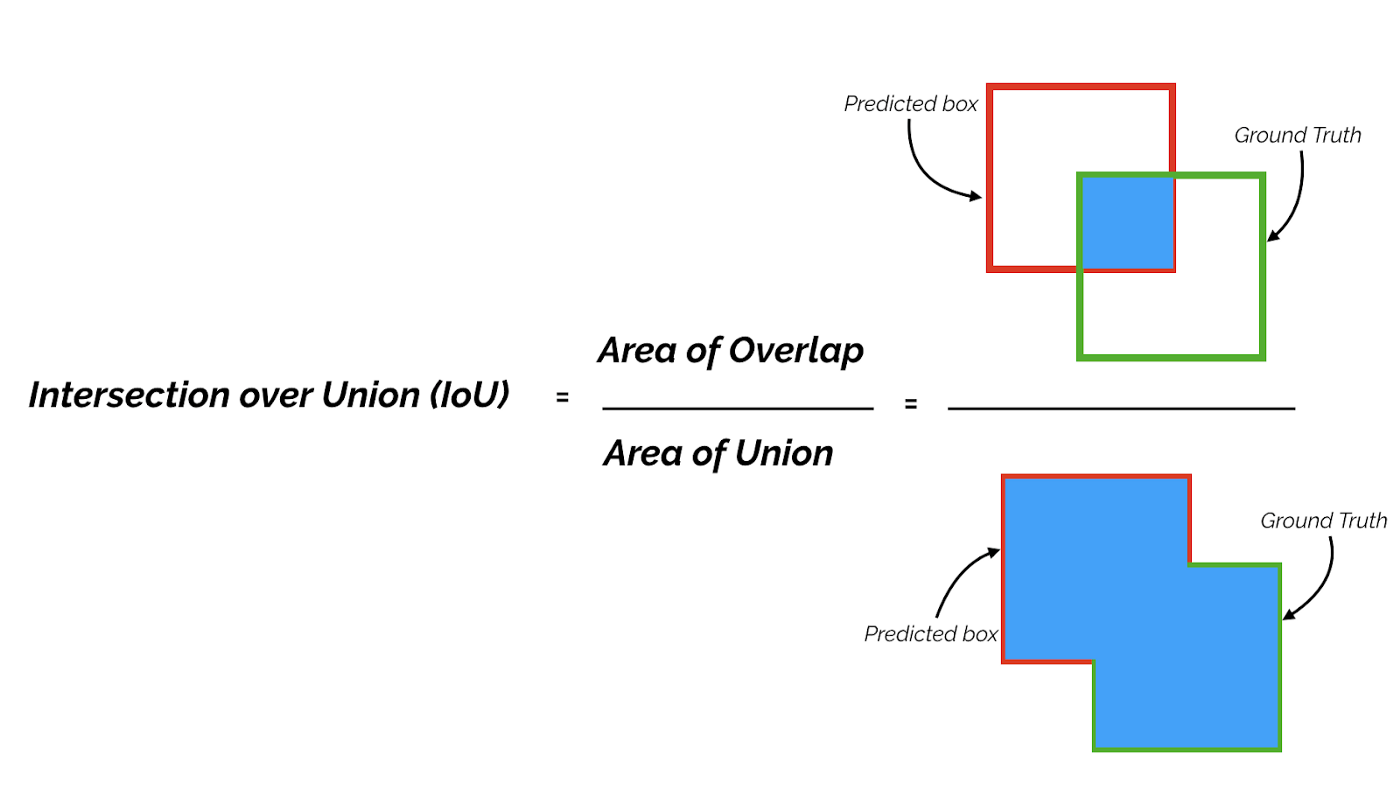
</div>

We calculate precision and recall using IoU value for a given IoU threshold.

1. Precision: It measures how accurate your predictions are i.e. the percentage of your predictions that are actually correct.
<div>
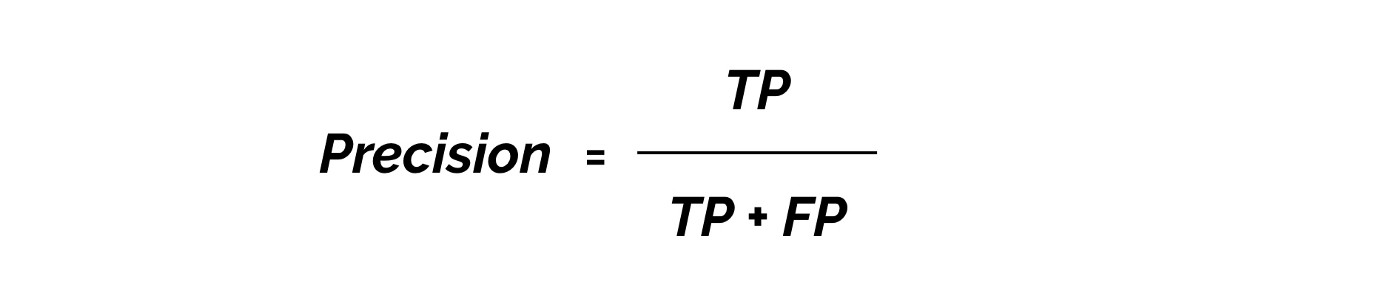
</div>
True Positive (TP): The predictions with IoU value greater than the threshold.<br>
False Positive (FP): The predictions with IoU value lower than the threshold.

2. Recall: It measures how well you find all the positives i.e. the percentage of total relevant results correctly classified by the model.
<div>
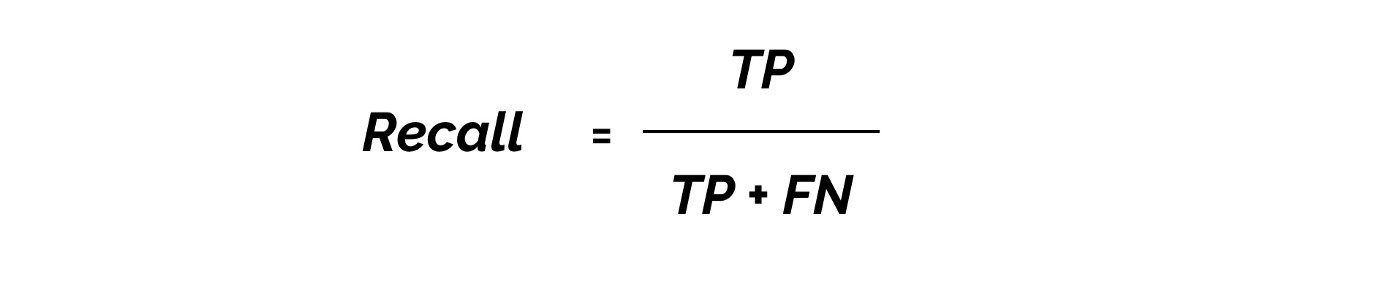
</div>
True Positive (TP): The predictions with IoU value greater than the threshold.<br>
False Negative (FN): The cases in which the model fails to detect the object when it is present.

3. mAP (Mean average precision): Average Precision (AP) is the area under the precision-recall curve.
AP is calculated for each class and averaged to get the mAP.
<div>
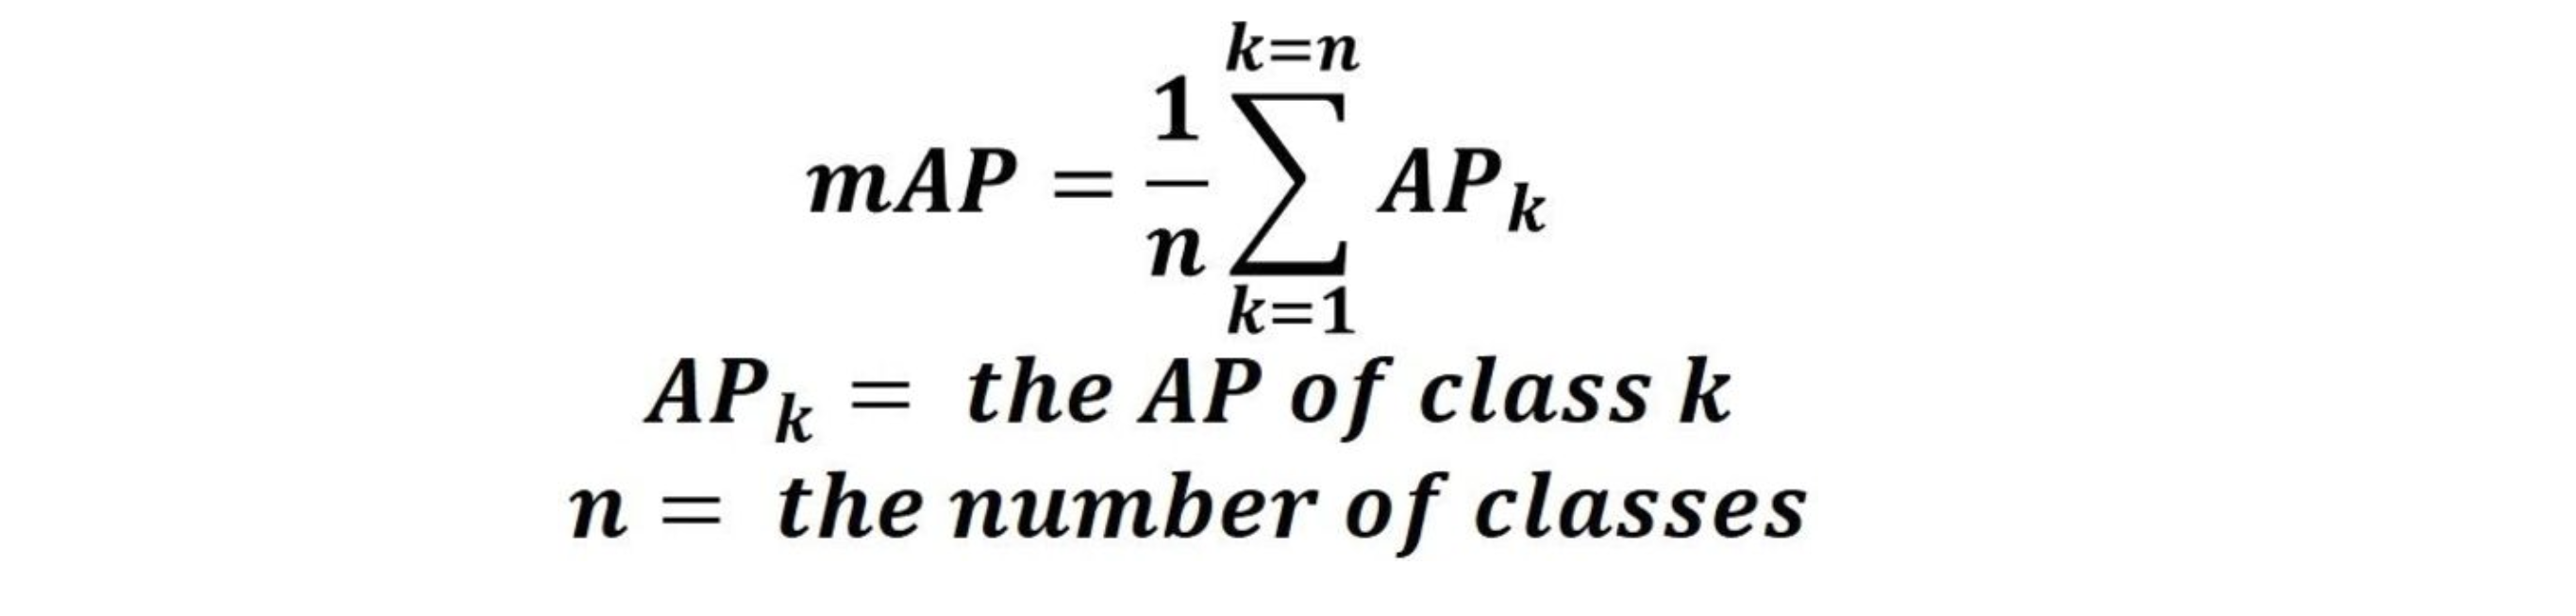
</div>


In [ ]:
get_model_response = ai_service_vision_client.client.get_model(model_id)

metrics = pd.DataFrame(columns = ["Metric", "Value"])
metrics.loc[0] = ["Precision", get_model_response.data.precision]
metrics.loc[1] = ["Recall", get_model_response.data.recall]
metrics.loc[2] = ["mAP", get_model_response.data.average_precision]

row_index = pd.Series(range(1, metrics.shape[0] + 1))
metrics = metrics.set_index([row_index])
metrics

## Custom model inference pipeline
The user can test the prediction endpoint with a sample image in this pipeline.
<ul>
    <li>The json output is saved as <code>response_image_object_detection.json</code> file in the <code>output</code> directory.</li>
    <li>Output image with bounding boxes is saved as <code>output_[input_file_name]</code>. It is also visualized in the last section of the notebook.</li>
    <li>Object labels are printed in descending order of their confidence levels after the visualized output.</li>
<ul>

### Imports

In [ ]:
import base64
import json
import io
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import oci
from helper.output_plot import OutputPlot
from helper.utils import display_classes

In [ ]:
input_path = "data/starbucks-cup.jpeg"
max_results = 5

### Get base64 encoded string of the image

In [ ]:
with open(input_path, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())

### Query the model endpoint
The object detection feature will use the model we trained above. Hence, the model ID is specified like this:<br>
<code>image_object_detection_feature.model_id = MODEL_ID </code>

In [ ]:
analyze_image_details = oci.ai_vision.models.AnalyzeImageDetails()
inline_image_details = oci.ai_vision.models.InlineImageDetails()

image_object_detection_feature = oci.ai_vision.models.ImageObjectDetectionFeature()
image_object_detection_feature.max_results = max_results
image_object_detection_feature.model_id = model_id
features = [image_object_detection_feature]
inline_image_details.data = encoded_string.decode('utf-8')
analyze_image_details.image = inline_image_details
analyze_image_details.features = features

res = ai_service_vision_client.client.analyze_image(analyze_image_details = analyze_image_details)

### Clean and save the API response as json

In [ ]:
res_json = json.loads(repr(res.data))
clean_res = clean_output(res_json)
with open('output/response_image_object_detection.json', 'w') as fp:
    json.dump(clean_res, fp)

### Add bounding boxes to the image
The user can verify that the test image is annotated properly.

In [ ]:
image_data = base64.b64decode(encoded_string)
image = Image.open(io.BytesIO(image_data))
output_plot = OutputPlot(image.width, image.height)
plt.gcf().set_dpi(200)
output_plot.plot.imshow(image)

box_properties = {}
if "image_objects" in clean_res:
    box_properties["linewidth"] = 2
    box_properties["edgecolor"] = 'red'
    output_plot.add_bounding_boxes(
        clean_res["image_objects"], box_properties, 0.5)

plt.axis('off')
plt.savefig("output/output_" + os.path.basename(input_path), dpi=200)

### Display the object labels with their confidence levels

In [ ]:
if 'image_objects' in clean_res:
    display_classes(clean_res['image_objects'])